# Segmenting and Clustering Neighborhoods in Toronto

In this assignment, we will be scraping postal code data from Wikipedia for the city of Toronto. In part 1, we will then wrangle and clean the data in order to get information about venues in the city's neighborhoods using the __Foursquare API__. Then, in part 2, we will use a _k_-means algorithm to cluster the neighborhoods by most popular venues. Finally, in part 3, we will visualize the clusters on a map of Toronto.

## Part 0 - Load Necessary Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import pgeocode  # get latitude and longitude from a postal code

import requests  # handle requests
from bs4 import BeautifulSoup  # web scraper

from pandas import json_normalize  # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium  # map rendering library

## Part 1 - Web Scraping
In this part, we will scrape a Wikipedia page containing a table of Toronto postal codes with their corresponding boroughs and neighborhoods.

Scrape the Wikipedia page using an HTML parser.

In [2]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=862527922'

req = requests.get(url)

soup = BeautifulSoup(req.content, 'html.parser')

Find the table in the HTML, and extract the data in each column. Then create a DataFrame to store all the data.

In [3]:
soup_table = soup.find('table')

# function to get the text from a list of HMTL tags
def get_text_map(lst):
    lst = list(map(lambda s: s.get_text(strip=True), lst))
    
    return lst

# get all the column data
data = soup_table.find_all('td')
data = get_text_map(data)

# get the data for each column
p_codes = data[::3]
bghs = data[1::3]
nbhs = data[2::3]

toronto_df = pd.DataFrame(zip(p_codes, bghs, nbhs), columns=['PostalCode', 'Borough', 'Neighborhood'])
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Filter out all the rows that have value of 'Not assigned' in the __Borough__ column. Also, if a neighborhood has a value of 'Not assigned', replace it with its borough.

In [4]:
# drop rows with no boroughs
toronto_df = toronto_df[toronto_df.Borough != 'Not assigned']

# confirm that there are no boroughs with the value 'Not assigned'
print(toronto_df['Borough'].value_counts())

Etobicoke           45
Scarborough         38
North York          38
Downtown Toronto    37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64


In [5]:
# replace 'Not assigned' neighborhoods with their boroughs
num_na_before = toronto_df[toronto_df['Neighborhood'] == 'Not assigned'].shape[0]

toronto_df['Neighborhood'] = np.where(toronto_df['Neighborhood'] == 'Not assigned', 
                                      toronto_df['Borough'], 
                                      toronto_df['Neighborhood'])
toronto_df.reset_index(inplace=True, drop=True)

num_na_after = toronto_df[toronto_df['Neighborhood'] == toronto_df['Borough']].shape[0]

# confirm that there are no neighborhoods with the value 'Not assigned'
# and that the count before and after is the same
print("Number of not assigned neighborhoods before:", num_na_before)
print("Number of not assigned neighborhoods after:", num_na_after)
print('\n')

Number of not assigned neighborhoods before: 1
Number of not assigned neighborhoods after: 1




For repeated boroughs, append all neighborhoods and separate them with a comma.

In [6]:
toronto_df = toronto_df.groupby(['PostalCode', 'Borough']).apply(lambda df: ", ".join(df['Neighborhood'])).reset_index(name='Neighborhood')
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Display the DataFrame as given by the assignment instructions.

In [7]:
# this is for the purpose of the assignment only
p_codes_lst = ['M5G', 'M2H', 'M4B', 'M1J', 'M4G', 'M4M', 'M1R', 'M9V', 'M9L', 'M5V', 'M1B', 'M5A']
toronto_df[toronto_df['PostalCode'].isin(p_codes_lst)].set_index('PostalCode').loc[p_codes_lst].reset_index()

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Woodbine Gardens, Parkview Hill"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,"Maryvale, Wexford"
7,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo..."


In [8]:
print("Number of rows in the full table:", toronto_df.shape[0])

Number of rows in the full table: 103


## Part 2 - Getting the Coordinates of Each Neighborhood
In this part we will be using the __pgeocode__ package to get the latitude and longitude values for each postal code.

In [9]:
# get the latitude and longitude of all the postal codes
country = 'CA'  # Canada
nomi = pgeocode.Nominatim(country)
lat_lng_df = nomi.query_postal_code(toronto_df.PostalCode.values)[['postal_code', 'latitude', 'longitude']]
lat_lng_df.drop_duplicates(inplace=True)
lat_lng_df.columns = ['PostalCode', 'Latitude', 'Longitude']

# join the two tables to append the latitude and longitude to our main table
toronto_df = toronto_df.join(lat_lng_df.set_index('PostalCode'), on='PostalCode')
toronto_df.dropna(inplace=True)  # drop rows with NaN latitude and/or longitude
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.8113,-79.1930
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7878,-79.1564
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7678,-79.1866
3,M1G,Scarborough,Woburn,43.7712,-79.2144
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389


Display the DataFrame as given by the instructions of the assignment.

In [10]:
toronto_df[toronto_df['PostalCode'].isin(p_codes_lst)].set_index('PostalCode').loc[p_codes_lst].reset_index()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.6564,-79.3860
1,M2H,North York,Hillcrest Village,43.8015,-79.3577
2,M4B,East York,"Woodbine Gardens, Parkview Hill",43.7063,-79.3094
3,M1J,Scarborough,Scarborough Village,43.7464,-79.2323
4,M4G,East York,Leaside,43.7124,-79.3644
5,M4M,East Toronto,Studio District,43.6561,-79.3406
6,M1R,Scarborough,"Maryvale, Wexford",43.7507,-79.3003
7,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.7432,-79.5876
8,M9L,North York,Humber Summit,43.7598,-79.5565
9,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.6404,-79.3995


## Part 3 - Explore and Cluster Toronto Neighborhoods
In this part, we will explore the venues where customers can buy drinks that are within a 2 kilometre radius from each postal code, and cluster the postal codes based on the type of venues.

Define the API credentials and version.

In [11]:
CLIENT_ID = 'O2H4MDSJF43NWSGKSSPCCUWB4MQUWYNSEXEOTTLCQEROO2BX' # your Foursquare ID
CLIENT_SECRET = '0F2EBKCGRLIUEVKN03DA2I4ZT1F3CET4SZQYJGDMJQAGI4EX' # your Foursquare Secret
VERSION = '20200428' # Foursquare API version

Function to get the venues and their corresponding information, for each postal code.

In [12]:
def GetVenues(postal_codes, boroughs, latitudes, longitudes, radius=2000, limit=100, section='coffee'):
    
    venue_lst = []
    
    for p_code, bgh, lat, lng in zip(postal_codes, boroughs, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&section={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            VERSION,
            radius,
            limit,
            section)

        venues = requests.get(url).json()['response']['groups'][0]['items']
        
        venue_lst.append([(
            p_code,
            bgh,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']
        ) for v in venues])
        
    nearby_venues = pd.DataFrame([item for venue_lst in venue_lst for item in venue_lst])
    nearby_venues.columns = ['PostalCode',
                             'Borough',
                             'Postal Code Latitude', 
                             'Postal Code Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']

    return nearby_venues

In [13]:
toronto_venues = GetVenues(toronto_df['PostalCode'],
                           toronto_df['Borough'],
                           toronto_df['Latitude'],
                           toronto_df['Longitude'],
                           section='drinks')  # section: filter by venues that provide drinks
toronto_venues.head()

,PostalCode,Borough,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,Scarborough,43.8113,-79.193,Toranj,43.818814,-79.204299,Bar
1,M1B,Scarborough,43.8113,-79.193,Tropical Nights,43.800955,-79.200427,Lounge
2,M1B,Scarborough,43.8113,-79.193,Boston Pizza,43.796470,-79.204245,Pizza Place
3,M1B,Scarborough,43.8113,-79.193,LTB is Here,43.796366,-79.204424,Bar
4,M1B,Scarborough,43.8113,-79.193,Having some beers,43.796317,-79.204297,Bar


Look at the number of venues per postal code. This will help us determine if we need to get rid of some of the rows.

In [14]:
toronto_venues['PostalCode'].value_counts()

M5C    100
M5A    100
M4X    100
M5K    100
M7A    100
M5E    100
M6K    100
M5H    100
M5V    100
M5B    100
M4Y    100
M5W    100
M5G    100
M5R    100
M5X    100
M5L    100
M5T    100
M6J    100
M6G     93
M6H     74
M5S     57
M6R     53
M4W     50
M4M     50
M4L     48
M6P     40
M4V     38
M4K     36
M4J     33
M4S     30
M5P     28
M2N     25
M4P     25
M4E     23
M4R     23
M4T     22
M6S     19
M6N     17
M4C     17
M5J     16
M8X     16
M2M     16
M5N     13
M2P     11
M6C     10
M8W     10
M1N     10
M8Z      9
M5M      9
M7Y      9
M8Y      9
M1H      8
M3J      8
M3C      8
M9M      8
M3K      7
M1R      7
M4H      7
M3B      7
M4N      6
M8V      6
M6E      6
M4A      6
M9R      6
M1S      6
M6B      6
M1B      5
M3H      5
M1P      5
M1T      5
M9P      5
M9W      5
M6M      5
M9N      5
M1M      5
M3A      5
M1L      5
M4B      5
M4G      5
M1W      4
M9B      4
M3L      4
M1C      4
M9L      4
M1J      4
M6A      4
M2H      4
M2J      4
M1E      4
M1K      4
M3N      4

We see that there are a lot of postal codes with less than 10 venues in a 2000 metre radius. We will filter out these rows because they don't have enough venues to give more accurate descriptions of the areas based on their surrounding venues.

In [15]:
toronto_venues_filtered = toronto_venues.groupby(['PostalCode', 'Borough']).filter(lambda x: len(x) > 10).reset_index(drop=True)
toronto_venues_filtered['PostalCode'].value_counts()

M5R    100
M5K    100
M5X    100
M5T    100
M6J    100
M5G    100
M5A    100
M5B    100
M5V    100
M5H    100
M4Y    100
M5L    100
M6K    100
M5W    100
M5C    100
M5E    100
M4X    100
M7A    100
M6G     93
M6H     74
M5S     57
M6R     53
M4M     50
M4W     50
M4L     48
M6P     40
M4V     38
M4K     36
M4J     33
M4S     30
M5P     28
M4P     25
M2N     25
M4R     23
M4E     23
M4T     22
M6S     19
M6N     17
M4C     17
M8X     16
M5J     16
M2M     16
M5N     13
M2P     11
Name: PostalCode, dtype: int64

One-hot encode the venues for each postal code and borough combination, in order to use them in the k-means algorithm later.

In [16]:
toronto_onehot = pd.get_dummies(toronto_venues_filtered[['PostalCode', 'Borough', 'Venue Category']], prefix="", prefix_sep="", columns=['Venue Category'])
toronto_onehot.head()

,PostalCode,Borough,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bar,Beach Bar,Beer Bar,Beer Garden,Belgian Restaurant,Boat or Ferry,Breakfast Spot,Brewery,Burger Joint,Butcher,Café,Cocktail Bar,Coffee Shop,Comedy Club,Diner,Dive Bar,Ethiopian Restaurant,Event Space,Festival,French Restaurant,Gastropub,Gay Bar,Hawaiian Restaurant,Hookah Bar,Hotel,Hotel Bar,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Korean Restaurant,Lounge,Music Venue,New American Restaurant,Nightclub,Nightlife Spot,Pizza Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Seafood Restaurant,Smoke Shop,Social Club,Spa,Speakeasy,Sports Bar,Steakhouse,Strip Club,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,M2M,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M2M,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M2M,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M2M,North York,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M2M,North York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Take the average occurence of each venue category for each postal code and borough combination. This will determine the frequency of occurrence of each venue in every postal code and borough.

In [17]:
toronto_grouped = toronto_onehot.groupby(['PostalCode', 'Borough']).mean().reset_index()
toronto_grouped.head()

,PostalCode,Borough,American Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bar,Beach Bar,Beer Bar,Beer Garden,Belgian Restaurant,Boat or Ferry,Breakfast Spot,Brewery,Burger Joint,Butcher,Café,Cocktail Bar,Coffee Shop,Comedy Club,Diner,Dive Bar,Ethiopian Restaurant,Event Space,Festival,French Restaurant,Gastropub,Gay Bar,Hawaiian Restaurant,Hookah Bar,Hotel,Hotel Bar,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Korean Restaurant,Lounge,Music Venue,New American Restaurant,Nightclub,Nightlife Spot,Pizza Place,Pub,Ramen Restaurant,Restaurant,Sake Bar,Seafood Restaurant,Smoke Shop,Social Club,Spa,Speakeasy,Sports Bar,Steakhouse,Strip Club,Sushi Restaurant,Thai Restaurant,Theme Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,M2M,North York,0.000000,0.0,0.0,0.000000,0.125000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0625,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.062500,0.0,0.0,0.0,0.0,0.062500,0.0,0.187500,0.0625,0.0625,0.0,0.0,0.0,0.000000,0.00,0.187500,0.0,0.000000,0.1875,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,M2N,North York,0.000000,0.0,0.0,0.000000,0.080000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,0.200000,0.0,0.160000,0.0400,0.0800,0.0,0.0,0.0,0.000000,0.04,0.120000,0.0,0.080000,0.0400,0.0,0.0,0.040000,0.0,0.0,0.04,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0
2,M2P,North York,0.000000,0.0,0.0,0.000000,0.090909,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.272727,0.0,0.090909,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.00,0.272727,0.0,0.090909,0.0000,0.0,0.0,0.090909,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,M4C,East York,0.058824,0.0,0.0,0.000000,0.235294,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117647,0.058824,0.0000,0.0,0.0,0.000000,0.058824,0.0,0.0,0.0,0.235294,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.058824,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.00,0.117647,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,M4E,East Toronto,0.000000,0.0,0.0,0.043478,0.173913,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.043478,0.000000,0.0,0.0,0.0,0.086957,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0000,0.0,0.0,0.0,0.043478,0.00,0.565217,0.0,0.043478,0.0000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [18]:
toronto_grouped.shape

(44, 62)

#### Determine the optimal k value for k-means
In order to determine the optimal value of k, we will use the Elbow Criterion.

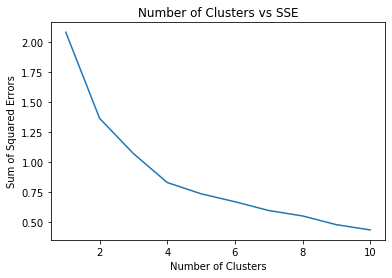

In [19]:
toronto_clustering = toronto_grouped.drop(['PostalCode', 'Borough'], 1)

# run the algorithm for different values of k and store the results in a set
sse = {}  # sum of squared errors
for k in range(1, 11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20).fit(toronto_clustering)
    
    sse[k] = kmeans.inertia_  # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors")
plt.title("Number of Clusters vs SSE")
plt.show()

From the plot we see that the value of _k_ that appears on the elbow is 4. Now we will run the algorithm with that value of k again.

In [37]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=20).fit(toronto_clustering)

toronto_labels = toronto_grouped[['PostalCode']]
toronto_labels.insert(0, 'ClusterLabel', kmeans.labels_)

toronto_merged = toronto_df.merge(toronto_labels.set_index('PostalCode'), how='inner', on='PostalCode')
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,ClusterLabel
0,M2M,North York,"Newtonbrook, Willowdale",43.7915,-79.4103,3
1,M2N,North York,Willowdale South,43.7673,-79.4111,3
2,M2P,North York,York Mills West,43.7500,-79.3978,3
3,M4C,East York,Woodbine Heights,43.6913,-79.3116,2
4,M4E,East Toronto,The Beaches,43.6784,-79.2941,1


Make sure that the number of rows of the merged table still match the number of rows of the table that was used in the k-means algorithm.

In [38]:
print("The number of rows match:", toronto_merged.shape[0] == toronto_grouped.shape[0])

The number of rows match: True


Now let's visualize the clusters on the map.

In [54]:
# create map
map_clusters = folium.Map(location=[43.65, -79.38], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, p_code, bgh, nbh, cluster in zip(toronto_merged['Latitude'],
                                               toronto_merged['Longitude'],
                                               toronto_merged['PostalCode'], 
                                               toronto_merged['Borough'],
                                               toronto_merged['Neighborhood'],
                                               toronto_merged['ClusterLabel']):
    
    label = folium.Popup(str(p_code) + ', ' + str(bgh) + ', ' + str(nbh) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [55]:
p_codes = toronto_merged.loc[toronto_merged['ClusterLabel'] == 0].PostalCode.values
toronto_venues.loc[toronto_venues['PostalCode'].isin(p_codes)]

,PostalCode,Borough,Postal Code Latitude,Postal Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1421,M5J,Downtown Toronto,43.6230,-79.3936,American Express Lounge,43.629560,-79.415360,Lounge
1422,M5J,Downtown Toronto,43.6230,-79.3936,Amsterdam Brewhouse,43.638122,-79.384803,Brewery
1423,M5J,Downtown Toronto,43.6230,-79.3936,Hunters Landing,43.640139,-79.396700,Restaurant
1424,M5J,Downtown Toronto,43.6230,-79.3936,Centre Island Beer Garden,43.616865,-79.372281,Beer Garden
1425,M5J,Downtown Toronto,43.6230,-79.3936,Fox & Fiddle,43.640053,-79.394025,Pub
1426,M5J,Downtown Toronto,43.6230,-79.3936,Market@416,43.631653,-79.394510,Bar
1427,M5J,Downtown Toronto,43.6230,-79.3936,Top Deck Bar,43.623618,-79.381325,Burger Joint
1428,M5J,Downtown Toronto,43.6230,-79.3936,Toronto Island Marina Yacht Club,43.623612,-79.381283,Bar
1429,M5J,Downtown Toronto,43.6230,-79.3936,Empire Sandy Tall Ship,43.636695,-79.391609,Boat or Ferry
1430,M5J,Downtown Toronto,43.6230,-79.3936,St. Louis Bar & Grill,43.640406,-79.390570,Bar


# TODO: look at the top venues per cluster in order to see how they were grouped